# Using Historical ML to Predict the Fate of Accused Witches 
Elda Pere, Carlos Calderon, Alejandro Pelcastre, Kevin Gu 


In this notebook, we attempt to answer the question: **How well can we predict whether a witch trial will end in execution using gender and gender related features?**. The data comes from the University of Edinburgh's Historical Scottish Witchcraft Dataset, with information dated between the 15th and 18th century in Scotland. This topic ties into modern-day sexism. The purpose of it is to understand the roots of gender equality issues in history to be able to better understand their evolution into sexism today.  

### Import Packages and Data

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import sklearn
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import urllib.request as urllib2 # For python3
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from collections import Counter
from imblearn.over_sampling import SMOTE
from scipy.stats import norm
from keras.models import Sequential
from keras.layers import Dense
import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from sklearn.model_selection import KFold

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
data = pd.read_csv("data/derived_accused_cases_trials.csv")
data.head(3)

,AccusedRef,AccusedSystemId,AccusedID,FirstName,LastName,M_Firstname,M_Surname,Alias,Patronymic,DesTitle,...,Exec_county,Exec_burgh,Exec_NGR_Letters,Exec_NGR_Easting,Exec_NGR_Northing,PostTrialNotes,Createdby_y,Createdate_y,Lastupdatedby_y,Lastupdatedon_y
0,A/EGD/10,EGD,10.0,Mareon,Quheitt,Marion,White,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,jhm,08/07/02 15:23:55,LEM,10/28/02 13:06:53
1,A/EGD/100,EGD,100.0,Thom,Cockburn,Thomas,Cockburn,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,LEM,07/24/02 16:01:21,LEM,07/24/02 16:01:23
2,A/EGD/1000,EGD,1000.0,Christian,Aitkenhead,Christine,Aikenhead,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,LEM,07/18/01 16:13:27,jhm,10/01/02 10:48:24


In [3]:
data.shape

(3795, 205)

### Preprocessing

In [4]:
# Features we are interested in 
list_of_trial_features = ['Execution', 'Noreftocentral', 'Localwithcrep', 'Circuit', 'Cjtorder', 'Defence', 'High_status', 
                          'Male_accusers', 'Female_accusers', 'Confrontingsuspects', 'ActionDropped', 'Fled', 'Arrest', 
                          'Watching', 'TrialType']

list_of_accused_features = ['AccusedRef', 'M_Firstname', 'M_Surname', 'Alias', 'Patronymic', 'DesTitle', 'Sex', 'Age', 
                            'Res_settlement', 'Res_parish', 'Res_presbytery',  'Res_county', 'Res_burgh', 'Ethnic_origin', 
                            'MaritalStatus', 'SocioecStatus', 'Occupation', 'Notes']

list_of_cases_features = ['CaseRef', 'CaseStart_date', 'CaseStart_date_as_date', 'Case_date', 'Case_date_as_date', 'Age_at_case', 
                          'CaseCommonName', 'Complaint', 'Correspondence', 'Chronicle', 'Suspects_text', 'Familiars', 'Shape-Changing', 
                          'Dreams/Visions', 'UnorthodoxReligiousPractice', 'SympatheticMagic', 'Ridingdead', 'FolkNotes', 
                          'HumanIllness', 'HumanDeath', 'AnimalIllness', 'AnimalDeath', 'FemaleInfertility', 'MaleImpotence', 
                          'AggravatingDisease', 'TransferringDisease', 'LayingOn', 'Removalbewitchment', 'Quarreling', 'Cursing', 
                          'Poisoning', 'RecHealer', 'HealingHumans', 'HealingAnimals', 'Midwifery', 'DiseaseNotes', 'PropertyDamage', 
                          'WeatherModification', 'OtherMaleficiaNotes', 'OtherChargesNotes', 'ClaimedBewitched', 'ClaimedPossessed', 
                          'AdmitLesserCharge', 'ClaimedNaturalCauses', 'Nodefence', 'DefenseNotes', 'CaseNotes', 'PoliticalMotive_s', 
                          'PropertyMotive_p', 'PropertyMotive_s', 'RefusedCharity_p', 'RefusedCharity_s', 'Treason_p', 'Treason_s', 
                          'Other_p', 'Other_s', 'OtherText', 'NotEnoughInfo_p', 'NotEnoughInfo_s', 'WhiteMagic_p', 'WhiteMagic_s', 
                          'Charnotes', 'DemonicPact', 'DevilNotes', 'WitchesMeeting', 'MeetingName', 'DevilPresent', 'Maleficium', 
                          'CommunalSex', 'DevilWorship', 'FoodAndDrink', 'Dancing', 'Singing', 'SingingText', 'OtherPractices', 
                          'MeetingNotes', 'Elphane/Fairyland', 'Food/Drink', 'SpecificVerbalFormulae', 'SpecificRitualActs', 
                          'UNorthodoxRelPract_p', 'UNorthodoxRelPract_s', 'Consulting_p', 'Consulting_s', 'Demonic_p', 'Demonic_s', 
                          'Demonic_possess_p', 'Demonic_possess_s', 'Fairies_p', 'Fairies_s', 'Folk_healing_p', 'Folk_healing_s', 
                          'Maleficium_p', 'Maleficium_s', 'Midwifery_p', 'Midwifery_s', 'ImplicatedByAnother_p', 'ImplicatedByAnother_s', 
                          'Neighbhd_dispute_p', 'Neighbhd_dispute_s', 'PoliticalMotive_p']

In [5]:
#Limit data to important features.
all_features = list_of_accused_features + list_of_cases_features + list_of_trial_features
df = data[all_features]

In [6]:
#Drop columns with more than 70% missing values.
percent_non_null = 0.8
df = df.dropna(axis = 1, thresh=df.shape[0]*percent_non_null)

In [7]:
df.describe(include="all")

,AccusedRef,M_Firstname,M_Surname,Sex,Res_county,CaseRef,Case_date,Case_date_as_date,CaseCommonName,Familiars,...,Defence,High_status,Male_accusers,Female_accusers,Confrontingsuspects,ActionDropped,Fled,Arrest,Watching,TrialType
count,3594,3550,3558,3544,3474,3788,3774,3773,3788,3788.000000,...,3211.000000,3211.000000,3209.000000,3208.000000,3211.000000,3211.000000,3211.00000,3211.000000,3211.000000,3211.000000
unique,3219,159,1168,2,34,3413,1164,1159,3047,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,A/EGD/1342,Janet,Thomson,Female,Haddington,C/EGD/1545,17/4/1662,04/17/62 00:00:00,3 unnamed witches,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,544,66,3030,658,3,93,93,109,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003432,...,0.013080,0.008409,0.418199,0.255923,0.032077,0.012457,0.03052,0.151355,0.006851,2.536593
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.058489,...,0.113635,0.091326,2.510500,1.627914,0.176233,0.110932,0.17204,0.358450,0.082502,0.927673
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,4.000000


In [8]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [9]:
missing_value_df.sort_values("percent_missing", ascending=False).head(5)

,column_name,percent_missing
Female_accusers,Female_accusers,15.467721
Male_accusers,Male_accusers,15.441370
TrialType,TrialType,15.388669
Noreftocentral,Noreftocentral,15.388669
Localwithcrep,Localwithcrep,15.388669


In [10]:
percent_missing = df.isna().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [11]:
missing_value_df.sort_values("percent_missing", ascending=True).head(5)


,column_name,percent_missing
WhiteMagic_p,WhiteMagic_p,0.184453
DevilWorship,DevilWorship,0.184453
CommunalSex,CommunalSex,0.184453
Maleficium,Maleficium,0.184453
DevilPresent,DevilPresent,0.184453


In [12]:
important_features = ['Execution', 'Arrest', 'Fled', 'ActionDropped', 'High_status', 'Male_accusers', 'Female_accusers', 
                      'WhiteMagic_p', 'WhiteMagic_s', 'Folk_healing_p', 'Folk_healing_s', 'Demonic_possess_p', 'Demonic_possess_s', 
                     'UNorthodoxRelPract_p', 'UNorthodoxRelPract_s', 'UnorthodoxReligiousPractice', 'HealingHumans', 'HealingAnimals', 
                     'Neighbhd_dispute_p', 'Neighbhd_dispute_s', 'PoliticalMotive_p', 'PoliticalMotive_s', 'PropertyMotive_p', 'PropertyMotive_s', 
                     'RefusedCharity_p', 'RefusedCharity_s', 'Treason_p', 'Treason_s', 'Quarreling', 'Cursing', 'Poisoning', 'RecHealer', 
                     'Dancing', 'Singing', 'Midwifery']

In [13]:
df_important_features = df[important_features]

In [14]:
# Add the sex column, but changed to 0-1 format
df_sex = pd.get_dummies(df.Sex)
df_important_features = pd.concat((df_sex, df_important_features), axis = 1)

In [15]:
df_important_features = df_important_features.drop(['Male'], axis = 1)
df_important_features = df_important_features.rename(columns={"Female": "Sex"})

In [16]:
important_features.insert(1, "Sex")
df_important_features = df_important_features.reindex(columns = important_features)

In [17]:
print("Female --> 1")
print("Male --> 0")
df_important_features.Sex.value_counts()

Female --> 1
Male --> 0


1    3030
0     765
Name: Sex, dtype: int64

In [18]:
def summary(feature):
    #Print out all feature values
    #print("The rows of the feature are," , str(feature))
    
    #print value counts
    print('' )
    print("The values are, ",feature.value_counts() )
    print('')
    
    #print most seen value
    mode = max(feature.value_counts())
    print("The most seen value is,", mode )
    print('')
    
    #Get unique values of feature
    output = []
    for x in feature.value_counts():
        if x not in output:
            output.append(x)
    print("The unique value counts are", output)

In [19]:
summary(df_important_features.Execution)


The values are,  0.0    2981
1.0     230
Name: Execution, dtype: int64

The most seen value is, 2981

The unique value counts are [2981, 230]


### Replacing Null Values
Deleted data columns that were not of type float. Then filled in NaN values with a random value from the column with probability proportional to the frequency of value in the column.

In [20]:
df_important_features['Sex']=df_important_features['Sex'].astype('float64')
integer_columns = df_important_features.select_dtypes(include=['int64']).columns #this list is empty but here to show I looked for integer types
float_columns = df_important_features.select_dtypes(include=['float64']).columns

#get columns with float dtypes
df_important_features = df_important_features[float_columns]

#For each column, sum all the values vertically and skip the null values
#Show the column and how many Null values
print('Total null values before transformation: ' + str(df_important_features.sum(axis = 0, skipna = True).sum()))
#sum up the values (to be used if we wanna incorporate filling with mean but I don't do it in this cell)
sum_series = df_important_features.sum(axis = 0, skipna = True)
columns = sum_series.index
    
for col in df_important_features:
    values = []
    for value in df_important_features[col]:
        if not np.isnan(value):
            values.append(value)
    if len(values) > 0:
        while df_important_features[col].isna().sum() > 0:
            df_important_features[col].fillna(random.choice(values), inplace = True, limit = 1)
    

Total null values before transformation: 8020.0


In [21]:
print('Total null values left in the data: ' + str(df_important_features[columns].isna().sum().sum()))

Total null values left in the data: 0


### Train/Test Split

In [22]:
X = df_important_features.drop('Execution', 1)
Y = df_important_features.Execution

train_test_split = int(0.8 * X.shape[0])
train_dev_split = (int)(2/3 * train_test_split)
train_data, train_labels = X[:train_dev_split], Y[:train_dev_split]
dev_data, dev_labels = X[train_dev_split:train_test_split], Y[train_dev_split:train_test_split]
test_data, test_labels = X[train_test_split:], Y[train_test_split:]

print("training data shape is:",train_data.shape, "Dev data shape is:", dev_data.shape, "Test data shape is:", test_data.shape)

training data shape is: (2024, 35) Dev data shape is: (1012, 35) Test data shape is: (759, 35)


C:\Users\ELDA~1.PER\AppData\Local\Temp/ipykernel_14428/4029769344.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_important_features.drop('Execution', 1)


### Applying SMOTE for Imbalanced Classes

In [23]:
#For Training Data: 
print("Rebalancing training data:")
# summarize class distribution
print("Classes before SMOTE: ")
counter = Counter(train_labels)
print(counter)
# transform the dataset
oversample_train = SMOTE(random_state=0)
train_data, train_labels = oversample_train.fit_resample(train_data, train_labels)
# summarize the new class distribution
print("Classes after SMOTE: ")
counter = Counter(train_labels)
print(counter)
print("-"*30)

#For Dev Data: 
print("Rebalancing development data:")
# summarize class distribution
print("Classes before SMOTE: ")
counter = Counter(dev_labels)
print(counter)
# transform the dataset
oversample_dev = SMOTE(random_state=0)
dev_data, dev_labels = oversample_dev.fit_resample(dev_data, dev_labels)
# summarize the new class distribution
print("Classes after SMOTE: ")
counter = Counter(dev_labels)
print(counter)
print("-"*30)

Rebalancing training data:
Classes before SMOTE: 
Counter({0.0: 1855, 1.0: 169})
Classes after SMOTE: 
Counter({0.0: 1855, 1.0: 1855})
------------------------------
Rebalancing development data:
Classes before SMOTE: 
Counter({0.0: 950, 1.0: 62})
Classes after SMOTE: 
Counter({0.0: 950, 1.0: 950})
------------------------------


### PCA, Fraction of Total Variance

,0
0,0.926756
1,0.971800
2,0.979372
3,0.983449
4,0.987165


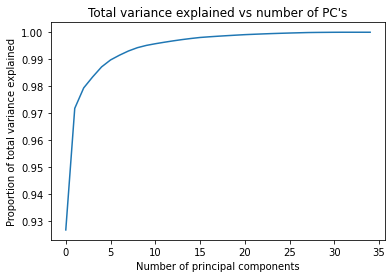

In [24]:
pca = PCA(n_components = train_data.shape[1])
X_train_pca = pca.fit_transform(train_data.fillna(0))
explained_variances = np.cumsum(pca.explained_variance_ratio_)

display(pd.DataFrame(explained_variances[:5]))

plt.plot(explained_variances);
plt.xlabel("Number of principal components");
plt.ylabel("Proportion of total variance explained");
plt.title("Total variance explained vs number of PC's");

Let's see what 2 principal components can capture in terms of the executed versus not executed!

Text(0.5, 1.0, "First two PC's, distinguished by executed vs non-executed")

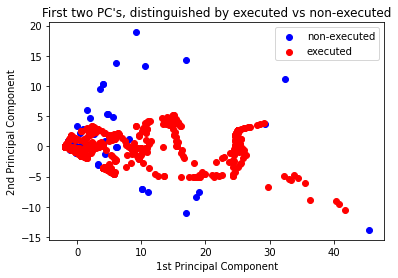

In [25]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(train_data)
X_train_pca_df = pd.DataFrame(X_train_pca)
X_train_pca_df = X_train_pca_df.assign(label = train_labels)
X_train_pca_df_non_executed, X_train_pca_df_executed = X_train_pca_df[X_train_pca_df['label'] == 0], X_train_pca_df[X_train_pca_df['label'] == 1]
plt.scatter(X_train_pca_df_non_executed.loc[:, 0], X_train_pca_df_non_executed.loc[:, 1], color = 'blue', label = "non-executed")
plt.scatter(X_train_pca_df_executed.loc[:, 0], X_train_pca_df_executed.loc[:, 1], color = 'red', label = "executed")
plt.legend()
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.title("First two PC's, distinguished by executed vs non-executed")

In [26]:
# List of additional PC's
pca_train_dataframes = []
pca_test_dataframes = []
for i in range(2, 7):
    pca_model = PCA(n_components=i)
    
    # Feature selection for training data
    pca_data = pca_model.fit_transform(train_data)
    pca_train_dataframes.append(pd.DataFrame(pca_data))
    
    # Feature selection for test data 
    # Currently replacing all NaN values with 0. Might change this 
    # based on what Alejandro figures out 
    pca_test = pca_model.transform(test_data.fillna(0))
    pca_test_dataframes.append(pd.DataFrame(pca_test))

pca_train_dataframes[3].head()

,0,1,2,3,4
0,-1.976260,-0.038349,-0.215238,0.146865,0.798647
1,-1.966097,-0.028108,-0.167386,-0.414219,-0.207967
2,-1.978383,0.005092,-0.163107,-0.009630,-0.177328
3,-1.978383,0.005092,-0.163107,-0.009630,-0.177328
4,-1.976260,-0.038349,-0.215238,0.146865,0.798647


### Logistic Regression

Our baseline model for this project will be a logistic regression model since we are working on a binary classification problem. After applying the transformations above, we experimented with different parameters such as using L1 regularization instead of the default L2. Although this would have reduce some features, the performance metrics did not improve (accuracy = 0.826) and so we kept the default value. 

In [27]:
lr_model = LogisticRegression(random_state = 0)

#Fit model then print the features with their coefficient values from the logistic regression model 
lr_model.fit(train_data, train_labels)
features_coef = []
for i in range(0, 35):
    features_coef.append((lr_model.coef_[0][i], train_data.columns[i]))

#score data
print("The model accuracy for the test data is: " + str(lr_model.score(test_data, test_labels)))
#Turn to data frame
coefs = pd.DataFrame(features_coef, columns=['Coefficient_value', 'Feature_name'])

The model accuracy for the test data is: 0.8247694334650857


C:\Users\elda.pere\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Below, we check p-values to see if we can reject the null hypothesis that the variables have no real effect on the 'Execution' variable. 

In [45]:
#Referenced from stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance  
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    #Adding noise to avoid perfect collinearity
    x = x+0.00001*np.random.rand(len(x), len(x.columns))
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

# test p-values
coefs['P Value'] = pd.DataFrame(logit_pvalue(lr_model, train_data))
coefs['Is Significant'] = coefs['P Value'] < 0.05
coefs['Odds Ratio'] = np.exp(coefs['Coefficient_value'])

In [46]:
coefs = coefs.sort_values(by = 'Coefficient_value', ascending = False)

In [47]:
coefs

,Coefficient_value,Feature_name,P Value,Is Significant,Odds Ratio
20,4.131388,PoliticalMotive_p,2.062592e-04,True,62.264269
31,2.435096,RecHealer,7.671994e-01,False,11.416920
29,1.159965,Cursing,1.173597e-01,False,3.189823
32,1.129170,Dancing,5.158335e-06,True,3.093089
11,0.875041,Demonic_possess_p,1.296042e-01,False,2.398975
1,0.847922,Arrest,4.933631e-02,True,2.334789
18,0.844677,Neighbhd_dispute_p,4.172336e-01,False,2.327226
4,0.653721,High_status,4.173210e-03,True,1.922683
10,0.503744,Folk_healing_s,3.951661e-01,False,1.654906
21,0.498711,PoliticalMotive_s,1.194293e-07,True,1.646598


In [48]:
#The coefficients with the maximum distance away from 0 are the more influential features. 
print("The top 5 significant features with an inverse relationship to 'Execution': ")
coefs['Feature_name'][coefs['Is Significant'] == True].head(5)


The top 5 significant features with an inverse relationship to 'Execution': 


20    PoliticalMotive_p
32              Dancing
1                Arrest
4           High_status
21    PoliticalMotive_s
Name: Feature_name, dtype: object

In [53]:
#The coefficients with the maximum distance away from 0 are the more influential features. 
print("The top 5 significant features with a linear relationship to 'Execution': ")
coefs['Feature_name'][coefs['Is Significant'] == True].tail(5)


The top 5 significant features with a linear relationship to 'Execution': 


2                   Fled
24      RefusedCharity_p
7           WhiteMagic_p
19    Neighbhd_dispute_s
33               Singing
Name: Feature_name, dtype: object

### Logistic Regression Performance

Finally, we visualize the performance of our model.

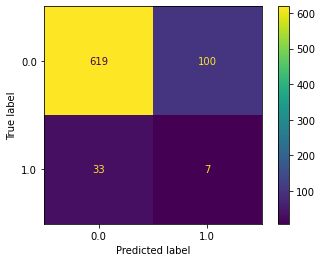

In [50]:
confusion_matrix = plot_confusion_matrix(lr_model, test_data, test_labels)
print(confusion_matrix)

In [51]:
y_pred_lr = lr_model.predict(test_data)
print(classification_report(test_labels, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90       719
         1.0       0.07      0.17      0.10        40

    accuracy                           0.82       759
   macro avg       0.51      0.52      0.50       759
weighted avg       0.90      0.82      0.86       759



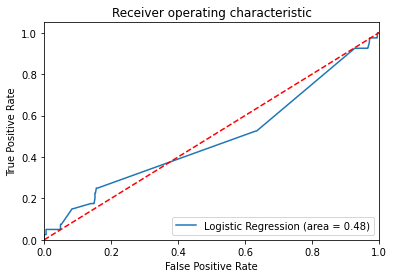

In [52]:
log_roc_auc = roc_auc_score(test_labels, lr_model.predict_proba(test_data)[:,1])
fpr, tpr, thresholds = roc_curve(test_labels, lr_model.predict_proba(test_data)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % log_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

To conclude the results of our baseline model, we learned that despite the performance shown in the ROC curve, there are a number of significant relationships within the data (see significance table above). **Most importantly, we found that gender related variables such as 'Sex', 'Midwifery', 'Dancing' and 'Singing' had statistically significant effects on whether the accused was executed. The model results show that the odds of a female accusee being executed were 1.3 times that of a male accusee, when controlling for all other variables.**

### Neural Net 

Below, we try to use more robust models that may find nonlinear patterns in the data. Although the nonlinear nature prevents us from interpreting the results and finding relationships as in the logistic regression, we hope to increase our model performance with additional freedoms.

In [36]:
# First, attempting to see whether I can get a keras neural net working 

# Applying dimensionality reduction to our data
X_train_nn = X_train_pca_df.iloc[:, 0:2]
train_labels_nn = X_train_pca_df.iloc[:, 2]

test_data_pca = pca.transform(test_data.fillna(0))
test_data_nn = pd.DataFrame(test_data_pca)

# Define the keras model 
model = Sequential()
model.add(Dense(12, input_dim=2, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# Compile the keras model 
model.compile(loss=keras.losses.BinaryCrossentropy(), 
              optimizer="adam", 
              metrics=[keras.metrics.BinaryAccuracy()])

# Fit the keras model 
model.fit(X_train_nn, train_labels_nn, epochs=150, batch_size=10, verbose=0)

# Evaluate the keras model 
_, binary_accuracy = model.evaluate(X_train_nn, train_labels_nn, verbose=0)
print(f"Training Binary Accuracy = {binary_accuracy}")

_, binary_accuracy= model.evaluate(test_data_nn, test_labels, verbose=0)     

#######Could the accuracy be different because you need test_labels_nn? ^
print(f"Testing Binary Accuracy = {binary_accuracy}")

Training Binary Accuracy = 0.6347708702087402
Testing Binary Accuracy = 0.8155467510223389


In [37]:
# Applying dimensionality reduction to our data
X_train_nn = X_train_pca_df.iloc[:, 0:2]
train_labels_nn = X_train_pca_df.iloc[:, 2]

test_data_pca = pca.transform(test_data.fillna(0))
test_data_nn = pd.DataFrame(test_data_pca)

In [38]:
inputs = np.concatenate((X_train_nn, test_data_nn), axis=0)
targets = np.concatenate((train_labels_nn, test_labels), axis=0)

In [39]:
def cross_validation(train_data, train_labels, test_data, test_labels, num_components):
    
    inputs = np.concatenate((train_data, test_data), axis=0)
    targets = np.concatenate((train_labels, test_labels), axis=0)
    
    num_folds = 10

    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=num_folds, shuffle=True)

    acc_per_fold = []
    loss_per_fold = []

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        # Define the keras model 
        model = Sequential()
        model.add(Dense(12, input_dim=num_components, activation="relu"))
        model.add(Dense(8, activation="relu"))
        model.add(Dense(1, activation="sigmoid"))

        # Compile the keras model 
        model.compile(loss=keras.losses.BinaryCrossentropy(), 
                      optimizer="adam", 
                      metrics=['accuracy'])


        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model.fit(inputs[train], 
                            targets[train], 
                            epochs=50, 
                            batch_size=10, 
                            verbose=0)

        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no = fold_no + 1
        
            # == Provide average scores ==
    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

In [40]:
for i in range(2, 7):
    
    cv_train_data = pca_train_dataframes[i - 2]
    cv_test_data = pca_test_dataframes[i - 2]
    cv_train_labels = train_labels
    cv_test_labels = test_labels
    
    print("-" * 30)
    print(f"Cross Validation Results for n={i} Principal Components")
    cross_validation(cv_train_data, cv_train_labels, cv_test_data, cv_test_labels, i)


------------------------------
Cross Validation Results for n=2 Principal Components
------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.5904633402824402; accuracy of 67.78523325920105%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.6126733422279358; accuracy of 68.90380382537842%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.5764731168746948; accuracy of 71.14093899726868%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.59419846534729; accuracy of 69.35123205184937%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.5923968553543091; accuracy of 70.24608254432678%
-----------------------------------------------

Score for fold 7: loss of 0.5558775663375854; accuracy of 72.48322367668152%
------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.5521815419197083; accuracy of 73.82550239562988%
------------------------------------------------------------------------
Training for fold 9 ...
Score for fold 9: loss of 0.5328426361083984; accuracy of 75.3915011882782%
------------------------------------------------------------------------
Training for fold 10 ...
Score for fold 10: loss of 0.5691804885864258; accuracy of 71.74887657165527%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5795114636421204 - Accuracy: 70.24608254432678%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5701945424079895 - Accuracy: 68.68008971214294%
--------------------------------

### Neural Net Performance

Visualizing model performance with the best hyperparameters.

In [41]:
y_pred = model.predict(test_data_nn)

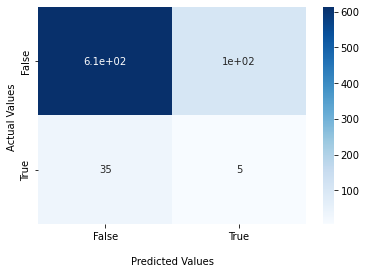

In [42]:
cf_matrix = pd.DataFrame(metrics.confusion_matrix(test_labels, 1*(y_pred>=0.5)))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [43]:
print(classification_report(test_labels, 1*(y_pred>=0.5)))

              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90       719
         1.0       0.05      0.12      0.07        40

    accuracy                           0.82       759
   macro avg       0.50      0.49      0.48       759
weighted avg       0.90      0.82      0.85       759



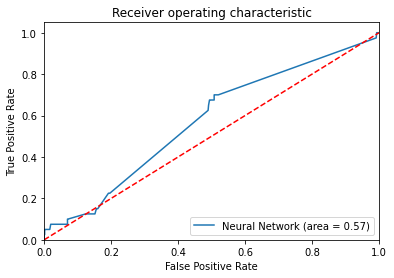

In [44]:
nn_roc_auc = roc_auc_score(test_labels, y_pred)
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Neural Network (area = %0.2f)' % nn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

**In conclusion, although we are more pleased with the performance of the neural network compared to the logistic regression model, explainability is more important than forecasting accuracy in this case, so we would choose the logistic regression.** Today, it is no longer necessary to predict witch trial executions, but it is necessary to be able to interpret the causes of these historical effects and to be able to make connections to gender issues that continue to exist today. 

### Thank you!